In [41]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import _pickle as pickle
from os import listdir
from os.path import join, isfile

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from keras import backend as K
K.set_session(session)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense

In [2]:
# Load labels and split to train/val
NUM_CLASSES = 120
SEED = 2914
np.random.seed(seed=SEED)
data_dir = '../data'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
l_val = labels.groupby('breed').apply(pd.DataFrame.sample, frac=0.2).reset_index(drop=True)
l_tr = labels.loc[~labels['id'].isin(l_val['id'])]
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print('Train:', len(listdir(join(data_dir, 'train'))), '=', len(l_tr)+len(l_val), '=', len(l_val), '+', len(l_tr))
print('Test:', len(listdir(join(data_dir, 'test'))), '=', len(sample_submission))

print("We should have {} clasess and the train data has {} classes."
      .format(NUM_CLASSES, len(l_tr.groupby('breed').count())))

l_tr_index = {label:i for i,label in enumerate(np.sort(np.unique(l_tr.breed)))}
l_tr_temp = [l_tr_index[label] for label in l_tr.breed]
l_val_temp = [l_tr_index[label] for label in l_val.breed]
y_tr = to_categorical(l_tr_temp ,num_classes=120)
y_val = to_categorical(l_val_temp ,num_classes=120)

print('y_tr shape: {}'.format(y_tr.shape))
print('y_val shape: {}'.format(y_val.shape))

Train: 10225 = 10222 = 2037 + 8185
Test: 10360 = 10357
We should have 120 clasess and the train data has 120 classes.
y_tr shape: (8185, 120)
y_val shape: (2037, 120)


In [3]:
filename = data_dir + '//train//xs_bf_inception_v3'
print('Loading from {}'.format(filename))
with open(filename, 'rb') as fp:
    xs_bf_inception = pickle.load(fp)
print('xs_bf_inception shape: {} size: {:,}'.format(xs_bf_inception.shape, xs_bf_inception.size))

filename = data_dir + '//train//xs_bf_xception'
print('Loading from {}'.format(filename))
with open(filename, 'rb') as fp:
    xs_bf_xception = pickle.load(fp)
print('xs_bf_xception shape: {} size: {:,}'.format(xs_bf_xception.shape, xs_bf_xception.size))

filename = data_dir + '//train//xs_bf_vgg16'
print('Loading from {}'.format(filename))
with open(filename, 'rb') as fp:
    xs_bf_vgg16 = pickle.load(fp)
print('xs_bf_vgg16 shape: {} size: {:,}'.format(xs_bf_vgg16.shape, xs_bf_vgg16.size))

xs_bf = pd.DataFrame(data=np.concatenate((xs_bf_inception.as_matrix(columns=xs_bf_inception.columns[0:]), xs_bf_xception.as_matrix(columns=xs_bf_xception.columns[1:]), xs_bf_vgg16.as_matrix(columns=xs_bf_vgg16.columns[1:])), axis=1), columns=['id']+list(range(4608)))
print('Concatenated features xs_bf shape: {} size: {:,}'.format(xs_bf.shape, xs_bf.size))

Loading from ../data//train//xs_bf_inception_v3
xs_bf_inception shape: (10222, 2049) size: 20,944,878
Loading from ../data//train//xs_bf_xception
xs_bf_xception shape: (10222, 2049) size: 20,944,878
Loading from ../data//train//xs_bf_vgg16
xs_bf_vgg16 shape: (10222, 513) size: 5,243,886
Concatenated features xs_bf shape: (10222, 4609) size: 47,113,198


In [4]:
# Split to train/val sets
x_tr = np.zeros((len(l_tr), xs_bf.shape[1]-1), dtype='float32')
for i, img_id in enumerate(l_tr['id']):
    x_tr[i] = xs_bf[xs_bf.id == img_id].values[0][1:]
print('Train bottleneck features shape: {} size: {:,}'.format(x_tr.shape, x_tr.size))

x_val = np.zeros((len(l_val), xs_bf.shape[1]-1), dtype='float32')
for i, img_id in enumerate(l_val['id']):
    x_val[i] = xs_bf[xs_bf.id == img_id].values[0][1:]
print('Validation bottleneck features shape: {} size: {:,}'.format(x_val.shape, x_val.size))

Train bottleneck features shape: (8185, 4608) size: 37,716,480
Validation bottleneck features shape: (2037, 4608) size: 9,386,496


In [51]:
# Setup model
model = Sequential()

model.add(Dense(100, input_shape=(4608,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
          
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.3))
    
model.add(Dense(120, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# best so far, loss=0.44, layers=100, 100, 120, dropouts=0.3, 0.3

Train on 8185 samples, validate on 2037 samples
Epoch 1/15
8185/8185 [==============================] - 2s - loss: 0.9424 - acc: 0.7111 - val_loss: 0.4723 - val_acc: 0.8522
Epoch 2/15
8185/8185 [==============================] - 2s - loss: 0.8570 - acc: 0.7278 - val_loss: 0.4426 - val_acc: 0.8571
Epoch 3/15
8185/8185 [==============================] - 2s - loss: 0.8204 - acc: 0.7448 - val_loss: 0.4369 - val_acc: 0.8591
Epoch 4/15
1888/2037 [==========================>...] - ETA: 0sTest loss: 0.453285573743
Test accuracy: 0.848797251005


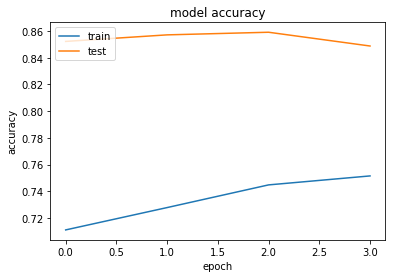

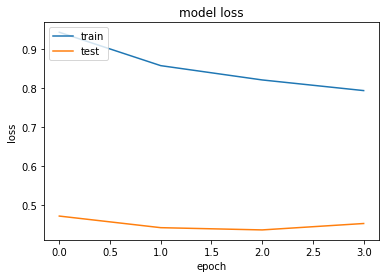

In [53]:
# Train
history = model.fit(x_tr, y_tr,
              batch_size=64,
              epochs=15,
              verbose=1,
              validation_data=(x_val, y_val),
              shuffle=True,
              callbacks=[EarlyStopping(monitor='val_loss')])

scores = model.evaluate(x_val, y_val, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
# Load test set data
filename = data_dir + '//test//xs_bf_inception'
print('Loading from {}'.format(filename))
with open(filename, 'rb') as fp:
    xs_bf_inception = pickle.load(fp)
print('xs_bf_inception shape: {} size: {:,}'.format(xs_bf_inception.shape, xs_bf_inception.size))

filename = data_dir + '//test//xs_bf_xception'
print('Loading from {}'.format(filename))
with open(filename, 'rb') as fp:
    xs_bf_xception = pickle.load(fp)
print('xs_bf_xception shape: {} size: {:,}'.format(xs_bf_xception.shape, xs_bf_xception.size))

filename = data_dir + '//test//xs_bf_vgg16'
print('Loading from {}'.format(filename))
with open(filename, 'rb') as fp:
    xs_bf_vgg16 = pickle.load(fp)
print('xs_bf_vgg16 shape: {} size: {:,}'.format(xs_bf_vgg16.shape, xs_bf_vgg16.size))

xs_test_bf = pd.DataFrame(data=np.concatenate((xs_bf_inception.as_matrix(columns=xs_bf_inception.columns[0:]), xs_bf_xception.as_matrix(columns=xs_bf_xception.columns[1:]), xs_bf_vgg16.as_matrix(columns=xs_bf_vgg16.columns[1:])), axis=1), columns=['id']+list(range(4608)))
print('Concatenated features xs_bf shape: {} size: {:,}'.format(xs_test_bf.shape, xs_test_bf.size))

Loading from ../data//test//xs_bf_inception
xs_bf_inception shape: (10357, 2049) size: 21,221,493
Loading from ../data//test//xs_bf_xception
xs_bf_xception shape: (10357, 2049) size: 21,221,493
Loading from ../data//test//xs_bf_vgg16
xs_bf_vgg16 shape: (10357, 513) size: 5,313,141
Concatenated features xs_bf shape: (10357, 4609) size: 47,735,413


In [54]:
# Predict
ys_test = model.predict(xs_test_bf.as_matrix(columns=xs_test_bf.columns[1:]), batch_size=200, verbose=1)
print('Predicted ys_test shape: {} size: {:,}'.format(ys_test.shape, ys_test.size))

10357/10357 [==============================] - 8s     
Predicted ys_test shape: (10357, 120) size: 1,242,840


In [55]:
# Save submission
for i, breed in enumerate(sample_submission.columns[1:]):
    sample_submission[breed] = ys_test[:, l_tr_index[breed]]
    
sample_submission.to_csv('..//submissions//sub_bottleneck_nn_inc_xc_vgg.csv', index=None)